# ML-7. Оптимизация гиперпараметров модели

## 4. Практика

>Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

>Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [ ]:
# Импорт библиотек
import numpy as np  # для матричных вычислений
import pandas as pd  # для анализа и предобработки данных
import matplotlib.pyplot as plt  # для визуализации
import seaborn as sns  # для визуализации
import optuna  # для автоматической оптимизации гиперпараметров

from sklearn import linear_model  # линейные модели
from sklearn import tree  # деревья решений
from sklearn import ensemble  # ансамбли моделей
from sklearn import metrics  # метрики оценки
from sklearn import preprocessing  # предобработка данных
from sklearn.model_selection import train_test_split  # сплитование выборки
from sklearn.model_selection import GridSearchCV  # поиск по сетке
from sklearn.model_selection import RandomizedSearchCV  # случайный поиск
from sklearn.model_selection import train_test_split, cross_val_score  # сплитование выборки и кросс-валидация
from sklearn.tree import DecisionTreeClassifier  # классификатор на основе дерева решений
from sklearn.ensemble import RandomForestClassifier  # классификатор на основе случайного леса
from sklearn.metrics import accuracy_score, f1_score  # метрики точности и F1-метрики
from scipy.stats import randint  # для генерации случайных чисел

from hyperopt import hp, tpe, fmin, Trials, STATUS_OK  # для автоматической оптимизации гиперпараметров
from hyperopt.pyll.base import scope  # для определения пространства поиска гиперпараметров

# Визуализация графиков в блокноте
%matplotlib inline
plt.style.use('seaborn')  # установка стиля графиков


#### Открываем и смотрим на данные

In [9]:
data = pd.read_csv('data/_train_sem09.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


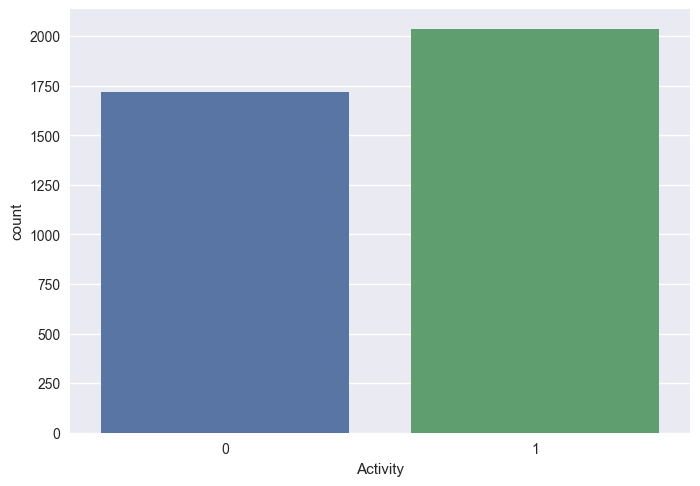

In [6]:
sns.countplot(data=data, x='Activity');

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [10]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

#### **Логистическая регрессия**


In [5]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

# accuracy на тестовом наборе: 0.76
# f1_score на тестовом наборе: 0.78

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


### <center> **GridSearchCV**

In [5]:
# Определение модели и параметров для поиска
model = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Создание GridSearchCV
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

# Поиск лучших параметров
grid_search.fit(X_train, y_train)

# Лучшие параметры и модель
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Лучшие параметры:", best_params)

# Оценка модели на тестовом наборе данных
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


# Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
# Fitting 5 folds for each of 108 candidates, totalling 540 fits
# CPU times: total: 25.2 s
# Wall time: 21min 46s
# accuracy на тестовом наборе: 0.80
# f1_score на тестовом наборе: 0.82

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 5 folds for each of 108 candidates, totalling 540 fits
CPU times: total: 25.2 s
Wall time: 21min 46s
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82


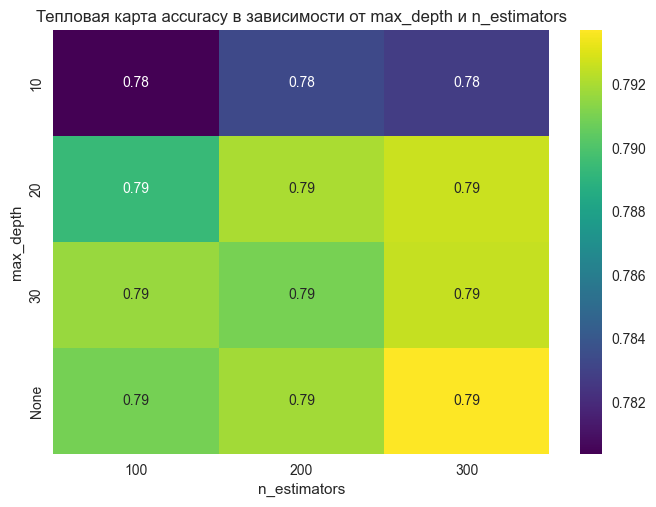

In [15]:
# Получение результатов grid search
results = pd.DataFrame(grid_search.cv_results_)

# Заполнение пропусков в столбце param_max_depth значением 'None'
results['param_max_depth'].fillna('None', inplace=True)

# Преобразование всех параметров в строки, чтобы избежать проблем с типами данных
results['param_max_depth'] = results['param_max_depth'].astype(str)
results['param_n_estimators'] = results['param_n_estimators'].astype(str)
results['param_min_samples_leaf'] = results['param_min_samples_leaf'].astype(str)
results['param_min_samples_split'] = results['param_min_samples_split'].astype(str)

# Удаление столбца params, так как он содержит словари
results = results.drop(columns=['params'])

# Группировка данных для устранения дубликатов
grouped_results = results.groupby(['param_max_depth', 'param_n_estimators']).mean(numeric_only=True).reset_index()

# Создание тепловой карты для max_depth и n_estimators
pivot_table = grouped_results.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Тепловая карта accuracy в зависимости от max_depth и n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()


**Вывод:** Наивысшая точность (0.80) достигается при max_depth=None и n_estimators=300. Это предполагает, что для данной модели и набора данных неограниченная глубина деревьев и большое количество деревьев дают наилучший результат.

In [7]:
# Взглянем на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search.cv_results_)
result_cv.head(2)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.380213,0.016290,0.023305,0.008167,None,sqrt,1,2,100,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.958333,0.958333,0.833333,1.0,0.958333,0.941667,0.056519,141
1,0.754775,0.017831,0.036384,0.001561,None,sqrt,1,2,200,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.958333,1.000000,0.833333,1.0,0.958333,0.950000,0.061237,17


### <center> **RandomizedSearchCV**

In [8]:

# Определение модели и параметров для случайного поиска
model = RandomForestClassifier()
param_dist = {
    'n_estimators': randint(200, 400),
    'max_depth': [None, 10],
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 4)
}

# Создание RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Поиск лучших параметров
randomized_search.fit(X_train, y_train)

# Лучшие параметры и модель
best_params = randomized_search.best_params_
best_model = randomized_search.best_estimator_

print("Лучшие параметры:", best_params)


# Оценка модели на тестовом наборе данных
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred, average='weighted')

%time randomized_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(randomized_search.score(X_test, y_test)))
y_test_pred = randomized_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


# Fitting 5 folds for each of 50 candidates, totalling 250 fits
# Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 333}
# Fitting 5 folds for each of 50 candidates, totalling 250 fits
# CPU times: total: 21.7 s
# Wall time: 15min 58s
# accuracy на тестовом наборе: 0.80
# f1_score на тестовом наборе: 0.83

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 333}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU times: total: 21.7 s
Wall time: 15min 58s
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.83


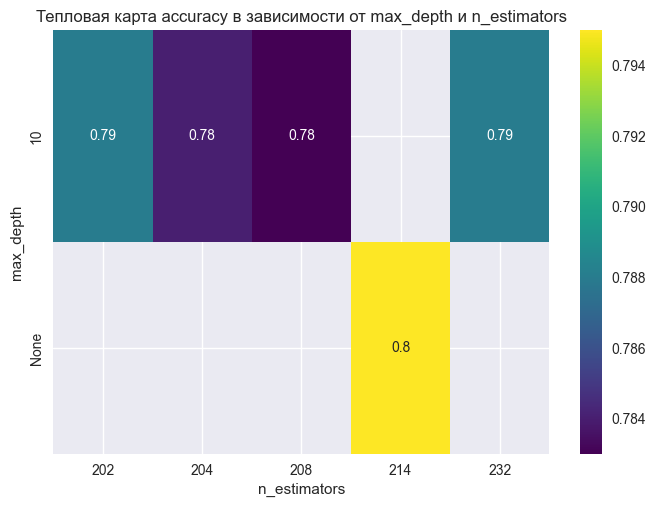

In [17]:
# Получение результатов grid search
results = pd.DataFrame(randomized_search.cv_results_)

# Заполнение пропусков в столбце param_max_depth значением 'None'
results['param_max_depth'].fillna('None', inplace=True)

# Преобразование всех параметров в строки, чтобы избежать проблем с типами данных
results['param_max_depth'] = results['param_max_depth'].astype(str)
results['param_n_estimators'] = results['param_n_estimators'].astype(str)
results['param_min_samples_leaf'] = results['param_min_samples_leaf'].astype(str)
results['param_min_samples_split'] = results['param_min_samples_split'].astype(str)

# Удаление столбца params, так как он содержит словари
results = results.drop(columns=['params'])

# Группировка данных для устранения дубликатов
grouped_results = results.groupby(['param_max_depth', 'param_n_estimators']).mean(numeric_only=True).reset_index()

# Ограничение количества значений n_estimators до 5
unique_estimators = sorted(grouped_results['param_n_estimators'].unique())[:5]
filtered_results = grouped_results[grouped_results['param_n_estimators'].isin(unique_estimators)]

# Создание тепловой карты для max_depth и n_estimators
pivot_table = filtered_results.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Тепловая карта accuracy в зависимости от max_depth и n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()


**Вывод:** Модель RandomForestClassifier с подобранными параметрами показала достаточно высокую точность и F1-метрику на тестовом наборе данных. Значение точности в 80% указывает на то, что 80% предсказаний модели были правильными. F1-метрика, равная 83%, также показывает хорошее качество предсказаний модели, учитывая баланс между точностью (precision) и полнотой (recall).

### <center> **Дерево решений**



In [20]:

# Определение модели и параметров для случайного поиска
model = DecisionTreeClassifier()
param_dist = {
    'max_depth': [None] + list(range(1, 21)),
    'min_samples_split': randint(2, 21),
    'min_samples_leaf': randint(1, 21),
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Создание RandomizedSearchCV
random_search_tree = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Поиск лучших параметров
random_search_tree.fit(X_train, y_train)

# Лучшие параметры и модель
best_params = random_search_tree.best_params_
best_model = random_search_tree.best_estimator_

print("Лучшие параметры:", best_params)


# Оценка модели на тестовом наборе данных
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


%time random_search_tree.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_tree.score(X_test, y_test)))
y_test_pred = random_search_tree.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

# CPU times: total: 2.62 s
# Wall time: 36 s
# accuracy на тестовом наборе: 0.76
# f1_score на тестовом наборе: 0.78


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Георгий\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
85 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Георгий\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Георгий\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Георгий\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklear

Лучшие параметры: {'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 13}
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Георгий\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
85 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Георгий\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Георгий\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Георгий\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklear

CPU times: total: 2.62 s
Wall time: 36 s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


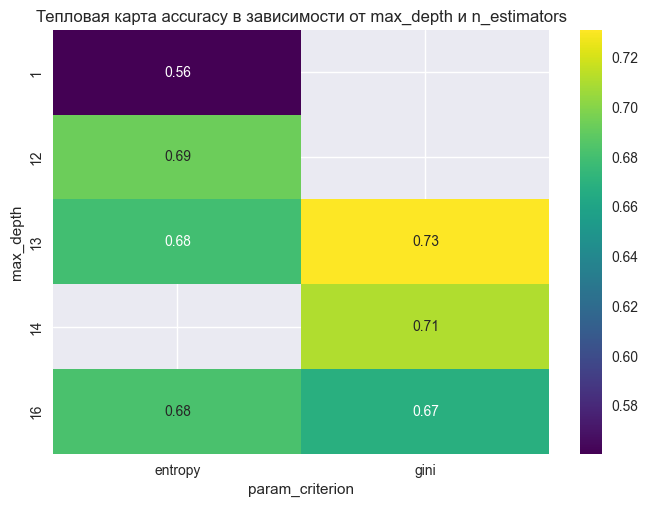

In [31]:
# Получение результатов grid search
results = pd.DataFrame(random_search_tree.cv_results_)

# Заполнение пропусков в столбце param_max_depth значением 'None'
results['param_max_depth'].fillna('None', inplace=True)

# Преобразование всех параметров в строки, чтобы избежать проблем с типами данных
results['param_max_depth'] = results['param_max_depth'].astype(str)
results['param_criterion'] = results['param_criterion'].astype(str)
results['param_min_samples_leaf'] = results['param_min_samples_leaf'].astype(str)
results['param_min_samples_split'] = results['param_min_samples_split'].astype(str)
results['param_max_features'] = results['param_max_features'].astype(str)

# Удаление столбца params, так как он содержит словари
results = results.drop(columns=['params'])

# Группировка данных для устранения дубликатов
grouped_results = results.groupby(['param_max_depth', 'param_criterion']).mean(numeric_only=True).reset_index()

# Ограничение количества значений n_estimators до 5
unique_estimators = sorted(grouped_results['param_max_depth'].unique())[:5]
filtered_results = grouped_results[grouped_results['param_max_depth'].isin(unique_estimators)]

# Создание тепловой карты для max_depth и n_estimators
pivot_table = filtered_results.pivot(index='param_max_depth', columns='param_criterion', values='mean_test_score')
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Тепловая карта accuracy в зависимости от max_depth и n_estimators')
plt.xlabel('param_criterion')
plt.ylabel('max_depth')
plt.show()


**Вывод:** При использовании случайного поиска с помощью RandomizedSearchCV для настройки параметров модели DecisionTreeClassifier произошло ухудшение метрик на тестовом наборе данных. Точность (accuracy) снизилась до 0.76, а F1-метрика до 0.78 по сравнению с предыдущими результатами.

---

In [6]:
# Определение модели и параметров для поиска
model = DecisionTreeClassifier()
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt']
}

# Создание GridSearchCV
grid_search_tree = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  # Уменьшено количество складок кросс-валидации
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'  # Также можно использовать 'f1_weighted' для оптимизации F1-метрики
)

# Поиск лучших параметров
grid_search_tree.fit(X_train, y_train)

# Лучшие параметры и модель
best_params = grid_search_tree.best_params_
best_model = grid_search_tree.best_estimator_

print("Лучшие параметры:", best_params)

# Оценка модели на тестовом наборе данных
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

%time grid_search_tree.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(accuracy))
print('f1_score на тестовом наборе: {:.2f}'.format(f1))

# Лучшие параметры: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
# Fitting 5 folds for each of 48 candidates, totalling 240 fits
# CPU times: total: 3.42 s
# Wall time: 1min 31s
# accuracy на тестовом наборе: 0.75
# f1_score на тестовом наборе: 0.75 - составь вывод

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Лучшие параметры: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Fitting 5 folds for each of 48 candidates, totalling 240 fits
CPU times: total: 3.42 s
Wall time: 1min 31s
accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.75


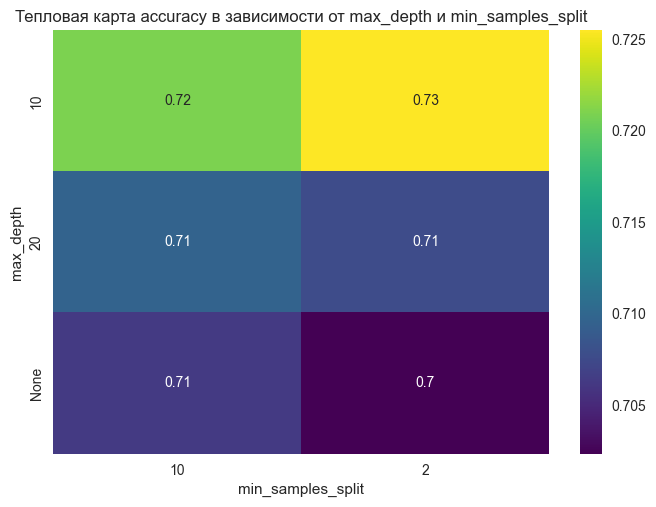

In [7]:
# Получение результатов grid search
results = pd.DataFrame(grid_search_tree.cv_results_)

# Заполнение пропусков в столбце param_max_depth значением 'None'
results['param_max_depth'].fillna('None', inplace=True)

# Преобразование всех параметров в строки, чтобы избежать проблем с типами данных
results['param_max_depth'] = results['param_max_depth'].astype(str)
results['param_min_samples_leaf'] = results['param_min_samples_leaf'].astype(str)
results['param_min_samples_split'] = results['param_min_samples_split'].astype(str)
results['param_criterion'] = results['param_criterion'].astype(str)
results['param_max_features'] = results['param_max_features'].astype(str)

# Удаление столбца params, так как он содержит словари
results = results.drop(columns=['params'])

# Группировка данных для устранения дубликатов
grouped_results = results.groupby(['param_max_depth', 'param_min_samples_split']).mean(numeric_only=True).reset_index()

# Создание тепловой карты для max_depth и min_samples_split
pivot_table = grouped_results.pivot(index='param_max_depth', columns='param_min_samples_split', values='mean_test_score')
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Тепловая карта accuracy в зависимости от max_depth и min_samples_split')
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.show()


**Вывод**

* Текущая точность (accuracy) составляет 0.75, что немного ниже по сравнению с предыдущей (0.76).
* Текущий F1-score также составляет 0.75, что ниже предыдущего значения (0.78).

---

### <center> Hyperopt

In [5]:

# Определение пространства поиска гиперпараметров
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 300, 50)),
    'max_depth': scope.int(hp.quniform('max_depth', 10, 30, 5)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 2)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 5, 1)),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_features': hp.choice('max_features', ['sqrt', 'log2'])
}

# Определение функции цели для оптимизации
def objective(params):
    clf = RandomForestClassifier(**params)
    score = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}

# Выполнение оптимизации с использованием Hyperopt
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            rstate=np.random.default_rng(42))

print("Наилучшие значения гиперпараметров:", best)

# Преобразование гиперпараметров для использования в модели
best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'min_samples_split': int(best['min_samples_split']),
    'min_samples_leaf': int(best['min_samples_leaf']),
    'criterion': ['gini', 'entropy'][best['criterion']],
    'max_features': ['sqrt', 'log2'][best['max_features']]
}

# Обучение модели с наилучшими параметрами
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

# Оценка модели на тестовом наборе данных
accuracy = best_model.score(X_test, y_test)
print("Точность на тестовом наборе: {:.2f}".format(accuracy))

y_test_pred = best_model.predict(X_test)
f1 = metrics.f1_score(y_test, y_test_pred, average='weighted')
print('F1-метрика на тестовом наборе: {:.2f}'.format(f1))


100%|██████████| 50/50 [13:20<00:00, 16.00s/trial, best loss: -0.7956666666666666]
Наилучшие значения гиперпараметров: {'criterion': 1, 'max_depth': 20.0, 'max_features': 0, 'min_samples_leaf': 1.0, 'min_samples_split': 6.0, 'n_estimators': 300.0}
Точность на тестовом наборе: 0.81
F1-метрика на тестовом наборе: 0.80


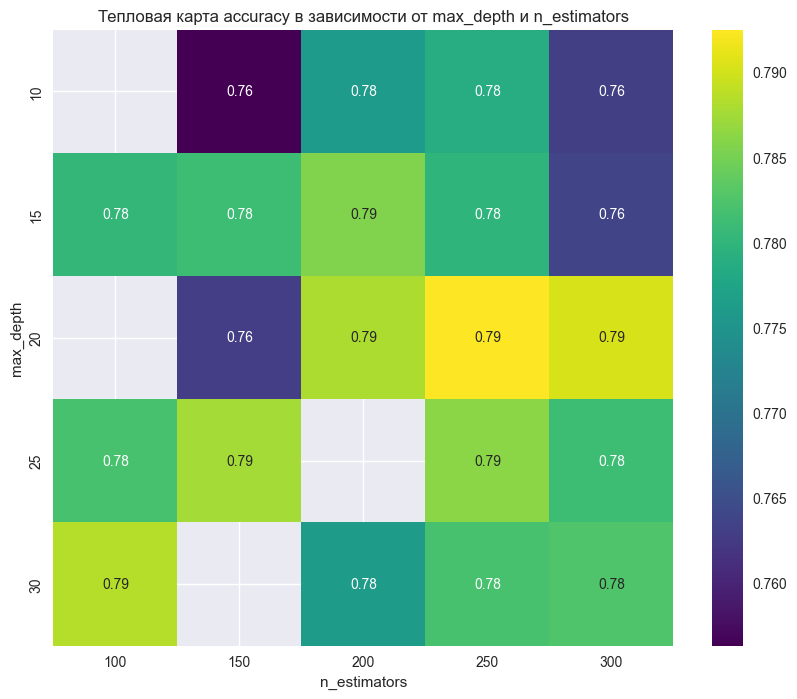

In [7]:

# Преобразование Trials в DataFrame
trials_dict = trials.results
trials_df = pd.DataFrame(trials_dict)

# Извлечение параметров из Trials
params_df = pd.DataFrame(trials.vals)
params_df['loss'] = trials_df['loss']
params_df['accuracy'] = -trials_df['loss']

# Преобразование параметров в строки для построения графиков
params_df['max_depth'] = params_df['max_depth'].astype(int).astype(str)
params_df['n_estimators'] = params_df['n_estimators'].astype(int).astype(str)

# Группировка данных и расчет среднего значения accuracy для каждой комбинации параметров
grouped_params = params_df.groupby(['max_depth', 'n_estimators']).mean().reset_index()

# Создание сводной таблицы для max_depth и n_estimators
pivot_table = grouped_params.pivot(index='max_depth', columns='n_estimators', values='accuracy')

# Создание тепловой карты для max_depth и n_estimators
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Тепловая карта accuracy в зависимости от max_depth и n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()


**Вывод:** Использование Hyperopt для оптимизации гиперпараметров привело к небольшой, но значимой улучшению производительности модели RandomForestClassifier по сравнению с предыдущими методами (GridSearchCV и DecisionTreeClassifier).

## <center> Optuna

In [12]:
# Определение функции оптимизации
def objective(trial):
    # Определение пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_features = trial.suggest_uniform('max_features', 0.2, 0.8)

    # Создание и обучение модели
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        max_features=max_features
    )

    # Оценка модели с использованием кросс-валидации
    score = cross_val_score(
        clf,
        X_train, 
        y_train, 
        cv=3,  # Уменьшено количество складок кросс-валидации
        scoring='accuracy',
        n_jobs=-1
    ).mean()
    return score

# Создание объекта для исследования с установленным генератором случайных чисел
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)

# Оптимизация с параллельным выполнением
study.optimize(objective, n_trials=50, n_jobs=-1)

print("Наилучшие значения гиперпараметров:", study.best_params)

# Использование наилучших гиперпараметров для обучения и оценки модели
best_params = study.best_params

best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    max_features=best_params['max_features']
)

best_model.fit(X_train, y_train)

accuracy = best_model.score(X_test, y_test)
print("Точность на тестовом наборе: {:.2f}".format(accuracy))

y_test_pred = best_model.predict(X_test)
f1 = metrics.f1_score(y_test, y_test_pred, average='weighted')
print('F1-метрика на тестовом наборе: {:.2f}'.format(f1))


[I 2024-05-28 11:33:04,139] A new study created in memory with name: no-name-656c6f60-12e9-490b-a9fd-66a1e60b1d45
C:\Users\Георгий\AppData\Local\Temp\ipykernel_2692\3916093398.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  max_features = trial.suggest_uniform('max_features', 0.2, 0.8)
C:\Users\Георгий\AppData\Local\Temp\ipykernel_2692\3916093398.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  max_features = trial.suggest_uniform('max_features', 0.2, 0.8)
C:\Users\Георгий\AppData\Local\Temp\ipykernel_2692\3916093398.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Наилучшие значения гиперпараметров: {'n_estimators': 194, 'max_depth': 50, 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'entropy', 'max_features': 0.2141213980879848}
Точность на тестовом наборе: 0.80
F1-метрика на тестовом наборе: 0.80


In [13]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [14]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

In [15]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

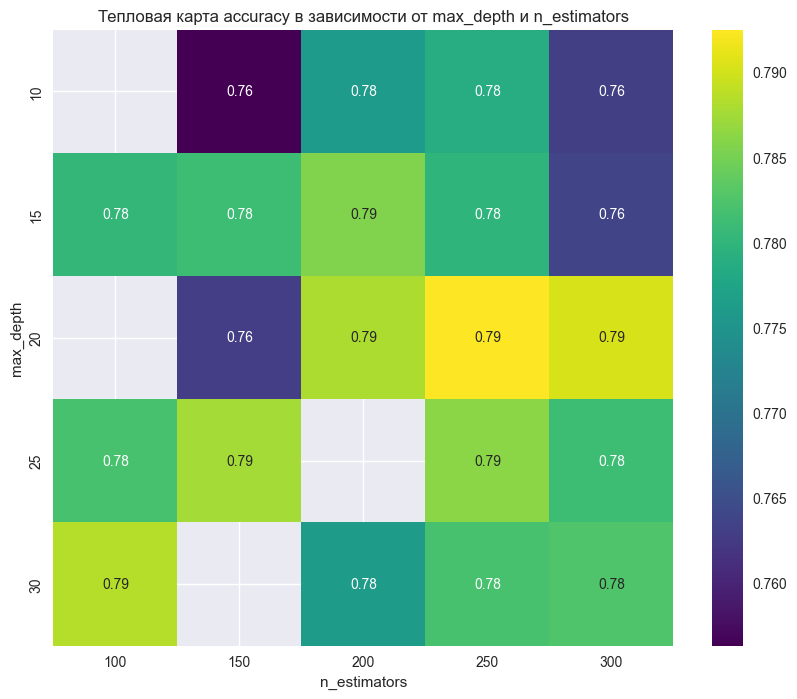

In [16]:
# Преобразование Trials в DataFrame
trials_dict = trials.results
trials_df = pd.DataFrame(trials_dict)

# Извлечение параметров из Trials
params_df = pd.DataFrame(trials.vals)
params_df['loss'] = trials_df['loss']
params_df['accuracy'] = -trials_df['loss']

# Преобразование параметров в строки для построения графиков
params_df['max_depth'] = params_df['max_depth'].astype(int).astype(str)
params_df['n_estimators'] = params_df['n_estimators'].astype(int).astype(str)

# Группировка данных и расчет среднего значения accuracy для каждой комбинации параметров
grouped_params = params_df.groupby(['max_depth', 'n_estimators']).mean().reset_index()

# Создание сводной таблицы для max_depth и n_estimators
pivot_table = grouped_params.pivot(index='max_depth', columns='n_estimators', values='accuracy')

# Создание тепловой карты для max_depth и n_estimators
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Тепловая карта accuracy в зависимости от max_depth и n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()


**Вывод:** Результаты показывают, что оптимизация гиперпараметров с использованием Optuna позволила достичь точности и F1-метрики на уровне 0.80 на тестовом наборе данных. Это свидетельствует о том, что подобранные гиперпараметры способствуют повышению производительности модели по сравнению с дефолтными настройками.

Модель| accuracy| f1_score
|--|--|--|
RandomForestClassifier - GridSearchCV | 0.80| 0.82
RandomForestClassifier - RandomizedSearchCV| 0.80| 0.83
DecisionTreeClassifier - RandomizedSearchCV | 0.76| 0.78
DecisionTreeClassifier - GridSearchCV | 0.75| 0.75
Hyperopt | 0.81 | 0.80
optuna | 0.80| 0.80

Основной  вывод:

* RandomForestClassifier с RandomizedSearchCV показал наилучшие результаты по F1-метрике (0.83):

Этот метод также показал высокую точность (0.80), что делает его предпочтительным выбором для задач, где важна точная классификация и балансировка классов.

* RandomForestClassifier с GridSearchCV также показал хорошие результаты:

Модель показала точность 0.80 и F1-метрику 0.82. GridSearchCV выполняет исчерпывающий поиск по пространству гиперпараметров, что приводит к хорошим результатам, но это может занять больше времени по сравнению с RandomizedSearchCV.

* Hyperopt продемонстрировал самую высокую точность (0.81):

Хотя F1-метрика немного ниже (0.80), использование Hyperopt для автоматической оптимизации гиперпараметров показало себя весьма эффективным.

* Optuna показала стабильные результаты:

Optuna продемонстрировала высокую точность (0.80) и F1-метрику (0.80), что делает её хорошим инструментом для оптимизации гиперпараметров, особенно учитывая её возможности для параллельной и распределённой оптимизации.

* DecisionTreeClassifier показывает более низкие результаты по сравнению с RandomForestClassifier:

RandomizedSearchCV для DecisionTreeClassifier показал точность 0.76 и F1-метрику 0.78, что выше, чем при использовании GridSearchCV (точность 0.75 и F1-метрика 0.75). Это подтверждает, что случайный поиск может быть более эффективным для деревьев решений.